# **Overview**
This document contains the algorithm our team created in Python to classify the type of failure in an Ion Mill Etching Tool. Our team consisted of 4 members


*   Kayla Berman
*   Julia Brace
*   Olivia Johnian
*   Jordan Lian

We would also like to thank our advisor Professor Jin, and our Design Review Dr. Shui of Ford Motors for all of their support and help with this project.

# **Data**
The data we got from the IME tool came from the [2018 PHM Data Challenge](
https://phmsociety.org/conference/annual-conference-of-the-phm-society/annual-conference-of-the-prognostics-and-health-management-society-2018-b/phm-data-challenge-6/). There were 20 overall tools worth of training, time to failure, and fault data. Due to the massive amount of data we were given, we decided to do work on one of the tools. The data itself is [here](https://drive.google.com/file/d/15Jx9Scq9FqpIGn8jbAQB_lcHSXvIoPzb/view), while the description of the problem is in the first link.

# **Packages**
Once we unzipped the file we were given, it was time to load in the data to Python. Most of these packages are standard, although we had to use a Google Drive package so we could import the data that we stored in our Drive folder. 





In [ ]:
# File Sizes
import os

# Standard Packages
import pandas as pd
import numpy as np
import random

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Google Drive Connector
from google.colab import drive

# Machine Learning: scikit-learn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import euclidean_distances

# Connect Google Drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load Data**
We used Pandas to load in data from Tool 01 (M01 and M02) as Pandas DataFrames. The size of the traiing files are massive, as we will show below.


In [ ]:
# Get path
def get_path(tool):
  train = "/content/drive/MyDrive/phm_data_challenge_2018/train/" + tool[:2] + "_" + tool[3:] + "_DC_train.csv"
  train_ttf = "/content/drive/MyDrive/phm_data_challenge_2018/train/train_ttf/" + tool[:2] + "_" + tool[3:] + "_DC_train.csv"
  train_faults = "/content/drive/MyDrive/phm_data_challenge_2018/train/train_faults/" + tool[:2] + "_" + tool[3:] + "_train_fault_data.csv"

  return train, train_ttf, train_faults

# Load Data Function
def load_data(tool):
  train_path, ttf_path, faults_path = get_path(tool)

  # Load data
  origin_train_data = pd.read_csv(train_path)
  origin_ttf_data = pd.read_csv(ttf_path)
  origin_fault_data = pd.read_csv(faults_path)

  return origin_train_data, origin_ttf_data, origin_fault_data

# Get file sizes
def file_size(tool):
  # Get path
  train_path, ttf_path, faults_path = get_path(tool)

  # Get file sizes
  train_size = "Training File Size: " + str(os.path.getsize(train_path) / 10**(9)) + " GB"
  ttf_size = "Time to Failure File Size: " + str(os.path.getsize(ttf_path) / 10**(9)) + " GB"
  fault_size = "Fault Data File Size: " + str(os.path.getsize(faults_path) / 10**(9)) + " GB"

  return train_size, ttf_size, fault_size

In [ ]:
# Make Copies of Original to Manipulate
train_data, ttf_data, fault_data = load_data("01 M01")

In [ ]:
# Show file sizes for Tool 01 M01
file_size("01 M01")

('Training File Size: 1.107918027 GB',
 'Time to Failure File Size: 0.103340393 GB',
 'Fault Data File Size: 1.044e-06 GB')

In [ ]:
# Show DataFrame
train_data

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,3283106,01M01,1,589,10511625,1,5.0,0.745235,1.085043,-1.151842,...,0.744638,0.727147,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
1,3283110,01M01,1,589,10511625,1,5.0,-0.037024,-0.932286,-1.152112,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
2,3283114,01M01,1,589,10511625,1,5.0,-0.507875,-1.106610,-1.151909,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
3,3283118,01M01,1,589,10511625,1,5.0,-0.793893,-1.128402,-1.151977,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
4,3283122,01M01,1,589,10511625,1,5.0,-0.977717,-1.128402,-1.151706,...,-1.312143,-1.405385,1.170894,-0.203892,-0.152495,0.0,-0.071733,-0.257798,0.862781,-0.200587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124699,43037320,01M01,1,8237,13062800,1,5.0,-1.339439,-1.128402,-1.152112,...,-1.296143,-1.269834,1.170894,-0.203892,-0.152501,0.0,0.760304,-1.213045,-0.857693,-0.200587
3124700,43037324,01M01,1,8237,13062800,1,5.0,-1.313654,-1.128402,-1.151706,...,-1.296143,-1.269834,1.170894,-0.203892,-0.152495,0.0,0.760304,-1.213045,-0.857693,-0.200587
3124701,43037328,01M01,1,8237,13062800,1,5.0,-1.337850,-1.128402,-1.151909,...,-1.296143,-1.269834,1.170894,-0.203892,-0.152495,0.0,0.760304,-1.213045,-0.857693,-0.200587
3124702,43037332,01M01,1,8237,13062800,1,5.0,-1.341035,-1.128402,-1.151977,...,-1.296143,-1.269834,1.170894,-0.203892,-0.152495,0.0,0.760304,-1.213045,-0.857693,-0.200587


In [ ]:
ttf_data

,time,TTF_FlowCool Pressure Dropped Below Limit,TTF_Flowcool Pressure Too High Check Flowcool Pump,TTF_Flowcool leak
0,3283106,3250078.0,9355132.0,16891832.0
1,3283110,3250074.0,9355128.0,16891828.0
2,3283114,3250070.0,9355124.0,16891824.0
3,3283118,3250066.0,9355120.0,16891820.0
4,3283122,3250062.0,9355116.0,16891816.0
...,...,...,...,...
3124699,43037320,NaN,NaN,NaN
3124700,43037324,NaN,NaN,NaN
3124701,43037328,NaN,NaN,NaN
3124702,43037332,NaN,NaN,NaN


In [ ]:
fault_data

,time,fault_name,Tool
0,6533184,FlowCool Pressure Dropped Below Limit,01M01
1,8286500,FlowCool Pressure Dropped Below Limit,01M01
2,8627086,FlowCool Pressure Dropped Below Limit,01M01
3,8697340,FlowCool Pressure Dropped Below Limit,01M01
4,8971484,FlowCool Pressure Dropped Below Limit,01M01
5,12638238,Flowcool Pressure Too High Check Flowcool Pump,01M01
6,12828064,FlowCool Pressure Dropped Below Limit,01M01
7,14026692,FlowCool Pressure Dropped Below Limit,01M01
8,15827488,FlowCool Pressure Dropped Below Limit,01M01
9,18573644,Flowcool Pressure Too High Check Flowcool Pump,01M01


In [ ]:
# Get data for Tool 01 M02
train_data_1, ttf_data_1, fault_data_1 = load_data("01 M02")

# **Data Exploration**
Here we decided to take a look at some of the data and do some exploratory analysis. We looked at the time series data, and we also conducted a correlation analysis. 

## **Time Series Data**
To display the sheer amount of data we had, we took Tool 01 M01 and plotted a subset of the time series data. We made this display dynamic in that the user could pick any of the 17 numerical sensors to visualize over time. The faults were shown with red (low flowcool pressure), green (high flowcool pressure), and orange (flowcool leak) vertical lines at their respective time(s).

In [ ]:
# Install Necessary Dependencies
!pip install jupyter_dash
!pip install dash

In [ ]:
# Dash Packages
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash.dependencies as dd

# Pandas
import pandas as pd

# Plotly
import plotly.graph_objects as go

# Google Drive
from google.colab import drive

# Connect Google Drive
drive.mount('/content/drive', force_remount=False)

def get_path(tool):
  train = "/content/drive/MyDrive/phm_data_challenge_2018/train/" + tool[:2] + "_" + tool[3:] + "_DC_train.csv"
  train_ttf = "/content/drive/MyDrive/phm_data_challenge_2018/train/train_ttf/" + tool[:2] + "_" + tool[3:] + "_DC_train.csv"
  train_faults = "/content/drive/MyDrive/phm_data_challenge_2018/train/train_faults/" + tool[:2] + "_" + tool[3:] + "_train_fault_data.csv"

  return train, train_ttf, train_faults

# Load Data Function
def load_data(tool):
  train_path, ttf_path, faults_path = get_path(tool)

  # Load data
  origin_train_data = pd.read_csv(train_path)
  origin_ttf_data = pd.read_csv(ttf_path)
  origin_fault_data = pd.read_csv(faults_path)

  return origin_train_data, origin_ttf_data, origin_fault_data

# Make Copies of Original to Manipulate
train_data, ttf_data, fault_data = load_data("01 M01")

merge = train_data.merge(fault_data, how='outer', on=['time', 'Tool'], 
                         left_on=None, right_on=None, left_index=False, 
                         right_index=False, sort=False, copy=True, 
                         indicator=False, validate=None)

merge = merge.sort_values(by='time', ascending=True)

variables = merge.columns[7:23].tolist()

# App ------------------------------------------------------------------------------------------------------------------
app = JupyterDash(__name__)
server = app.server

# Layout
app.layout = html.Div(children=[
    # Title
    html.H1(children='Time Series Plots of Features'),
    html.P(children="Below is a dynamic data visual showing the raw time series data (not normalized) for all the "
                    "numerical sensors for Tool 01 M01. We plotted a subset of 4 million seconds worth of data."),

    # Dropdown menu
    dcc.Dropdown(
        id='feature',
        options=[{'label': name, 'value': name} for name in variables],
        value=variables[0],
    ),

    # Graph
    dcc.Graph(
        id='time-series'
    ),
])

# End of App Code ------------------------------------------------------------------------------------------------------

# Callback function -- this make it dynamic
@app.callback(
    dd.Output('time-series', 'figure'),
    [dd.Input('feature', 'value')]
)

def time_series(variable):
  # Time bounds for data
  lower_bound = 15000000
  upper_bound = 19000000

  # Get subset
  train_n = merge[merge['time'].between(lower_bound, upper_bound, inclusive=True)]
  fault_n = fault_data[fault_data['time'].between(lower_bound, upper_bound, inclusive=True)]

  # Initialize
  fig = go.Figure()

  # Main Graph
  fig.add_trace(go.Scatter(x=list(train_n['time']), y=list(train_n[variable])))

  # Add fault lines
  fault_records = len(fault_n)

  # Min and Max for Vertical Lines
  minimum = min(train_n[variable])
  maximum = max(train_n[variable])

  for index in range(0, fault_records):
    # Get fault type for instance
    fault_type = fault_n.iloc[index, 1]

    # Get matching time
    time = fault_n.iloc[index, 0]

    # Line color depending on fault type
    if fault_type == "FlowCool Pressure Dropped Below Limit":
      line_color = "red"
    elif fault_type == "Flowcool Pressure Too High Check Flowcool Pump":
      line_color = "green"
    elif fault_type == "Flowcool leak":
      line_color = "DarkOrange"

    # Code vertical line for fault
    fig.add_shape(type="line", x0=time, y0=minimum, x1=time, y1=maximum, line=dict(color=line_color, width=2))

  # Range slider
  fig.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="linear"))

  return fig

app.run_server(debug=True, dev_tools_ui=True, dev_tools_hot_reload=True, threaded=True, mode='inline', port=8090)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

# **Dimension Reduction**
## **Correlation Analysis**
We first had to conduct a correlation analysis to find highly correlated variables. Highly correlated variables in a machine learning algorithm are redundant to the model and can cause overfitting. Here, is our initial correlation that we got for the original 17 sensors before narrowing it down to 6. Any variable pair with a correlation value above 0.75 was considered to be highly correlated.

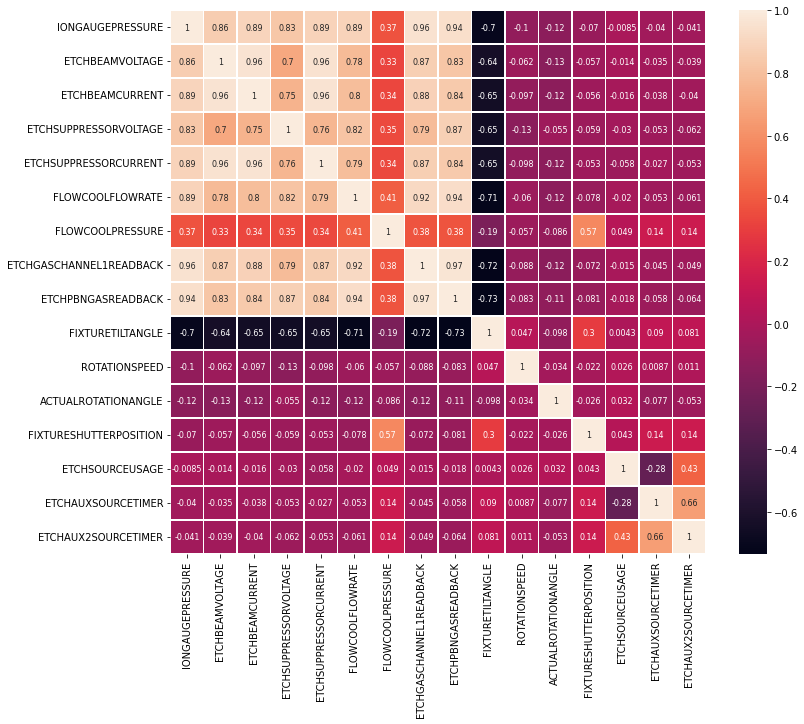

In [ ]:
plt.figure(figsize=(12,10))

features_corr = train_data.iloc[:, 7:23].corr()
sns.heatmap(features_corr, annot = True, linewidths=.5, annot_kws={"fontsize":8})

plt.show()

In [ ]:
# Normalization Function
def norm(train, fault):
  merge = train.merge(fault, how='outer', on=['time', 'Tool'], left_on=None, right_on=None, left_index=False, right_index=False, sort=False, copy=True, indicator=False, validate=None)
  merge = merge.sort_values(by='time', ascending=True)

  # Get columns that we chose to get
  merge = merge[['time', 'ETCHBEAMVOLTAGE', 'FLOWCOOLFLOWRATE', 'FLOWCOOLPRESSURE', 'ETCHPBNGASREADBACK', 'FIXTURETILTANGLE', 'FIXTURESHUTTERPOSITION', 'fault_name']]

  # copy the data
  norm_merge = merge.copy()
  
  # apply normalization techniques
  for column in norm_merge[['ETCHBEAMVOLTAGE', 'FLOWCOOLFLOWRATE', 'FLOWCOOLPRESSURE', 'ETCHPBNGASREADBACK', 'FIXTURETILTANGLE', 'FIXTURESHUTTERPOSITION']]:
    norm_merge[column] = norm_merge[column]  / norm_merge[column].abs().max()
  
  # view normalized data
  return norm_merge

In [ ]:
# First tool
norm_merge = norm(train_data, fault_data)

# Second tool
norm_merge_1 = norm(train_data_1, fault_data_1)

In [ ]:
norm_merge

,time,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHPBNGASREADBACK,FIXTURETILTANGLE,FIXTURESHUTTERPOSITION,fault_name
0,3283106,0.436283,-0.540298,-0.021749,0.283779,0.089118,0.0,NaN
1,3283110,-0.374861,-0.540298,-0.054251,-0.548470,0.089118,0.0,NaN
2,3283114,-0.444955,-0.540298,-0.063336,-0.548470,0.089118,0.0,NaN
3,3283118,-0.453717,-0.540298,-0.067656,-0.548470,0.089118,0.0,NaN
4,3283122,-0.453717,-0.540298,-0.073107,-0.548470,0.089118,0.0,NaN
...,...,...,...,...,...,...,...,...
3124699,43037320,-0.453717,-0.536627,-0.086229,-0.495569,0.089118,0.0,NaN
3124700,43037324,-0.453717,-0.536627,-0.108395,-0.495569,0.089118,0.0,NaN
3124701,43037328,-0.453717,-0.536627,-0.113442,-0.495569,0.089118,0.0,NaN
3124702,43037332,-0.453717,-0.536627,-0.117116,-0.495569,0.089118,0.0,NaN


## **Data Compression**
Given the size of the data and the scope of our problem, the team decided to compress the data using window chunks and get the summary statistics of certain features in that said window for faults and normal points. We got summary statistics from the following 6 features (narrowed down from 17).

- ETCHBEAMVOLTAGE
- FLOWCOOLFLOWRATE
- FLOWCOOLPRESSURE
- ETCHPBNGASREADBACK
- FIXTURETILTANGLE
- FIXTURESHUTTERPOSITION

### **Compressing the Fault Data**
To compress the fault data, we got all of the fault times, and then took the prior 50 data points before each respective fault, and grabbed the descriptive statistics of the six sensors mentioned above. Those statistics represented the 50 data points in one new data record.

In [ ]:
def fault_cycles(dataset):
  # Get fault points only, and get respective index rows (left-most column that is in bold)
  fault_data = dataset[~dataset['fault_name'].isna()]
  fault_times = list(fault_data['time'])

  # window size
  window = 50
  
  variables = ['ETCHBEAMVOLTAGE', 'FLOWCOOLFLOWRATE', 'FLOWCOOLPRESSURE', 'ETCHPBNGASREADBACK', 'FIXTURETILTANGLE', 'FIXTURESHUTTERPOSITION']
  mean_list = []
  stdev_list = []
  range_list = []

  # Make DF column names
  names = []

  # Counter for making DataFrame in first iteration
  counter = 0

  # Create column names for each variable (mean and standard deviation)
  for stat in variables:
    # Mean
    mean_name = stat + "_mean"
    names.append(mean_name)

    # Standard Deviation
    stdev_name = stat + "_stdev"
    names.append(stdev_name)

    # Range
    range_name = stat + "_range"
    names.append(range_name)


  # Add fault_name column
  names.append("Condition")

  # Creates list for good fault times (those with sufficient previous data for a fault cycle)
  good_fault_times = []

  # Iterate through fault_times
  for time in fault_times:

    # Get index number
    index_num = dataset.index[dataset['time'] == time].tolist()[0]

    # Use index to get the prior data points to form window
    df = dataset.loc[:index_num].tail(window)

    # Adds the points in each fault's cycle to a list 
    previous_points = df['time'].head(window-1).tolist() 
  
    # Checks if these previous points are faults themselves - if not adds to the good fault list
    fault_overlap = [i for i in previous_points if i in fault_times]

    if len(fault_overlap) == 0:
      good_fault_times.append(time)

  # Iterates through good faults (those with acceptable cycles)
  for time in good_fault_times:

    index_num_2 = dataset.index[dataset['time'] == time].tolist()[0]
    df_2 = dataset.loc[:index_num_2].tail(window)

    # Initialize list for new row
    row_list = []
  
    # For each variable, get the statistic, and then add to row_list[]
    for feature in variables:
      # Mean
      mean = df_2[feature].mean()
      row_list.append(mean)

      # Standard Deviation
      stdev = df_2[feature].std()
      row_list.append(stdev)

      # range - which i think is also peak to peak
      range = df_2[feature].max() - df_2[feature].min()
      row_list.append(range)


    # Get fault type based on index
    fault_type = fault_data['fault_name'].loc[index_num_2]

    # Add fault type to list for DataFrame
    row_list.append(fault_type)

    # If this is the first iteration, make new DataFrame, if not then add the latest row to new DataFrame
    if counter == 0:
      compress_df = pd.DataFrame(data=[row_list], columns = names)
    elif counter != 0:
      compress_df2 = pd.DataFrame(data=[row_list], columns = names)
      compress_df = compress_df.append(compress_df2, ignore_index=True) 
  
    # Counter Increase by 1
    counter += 1

  return compress_df

In [ ]:
# Call function
compress_df = fault_cycles(norm_merge)
compress_df_1 = fault_cycles(norm_merge_1)

In [ ]:
# Show compressed DataFrame
compress_df

,ETCHBEAMVOLTAGE_mean,ETCHBEAMVOLTAGE_stdev,ETCHBEAMVOLTAGE_range,FLOWCOOLFLOWRATE_mean,FLOWCOOLFLOWRATE_stdev,FLOWCOOLFLOWRATE_range,FLOWCOOLPRESSURE_mean,FLOWCOOLPRESSURE_stdev,FLOWCOOLPRESSURE_range,ETCHPBNGASREADBACK_mean,ETCHPBNGASREADBACK_stdev,ETCHPBNGASREADBACK_range,FIXTURETILTANGLE_mean,FIXTURETILTANGLE_stdev,FIXTURETILTANGLE_range,FIXTURESHUTTERPOSITION_mean,FIXTURESHUTTERPOSITION_stdev,FIXTURESHUTTERPOSITION_range,Condition
0,0.017019,4.239895e-01,0.890726,0.065534,3.428653e-01,0.800431,-0.004715,6.572306e-02,0.155595,0.012179,3.758866e-01,0.912448,-0.003474,6.713126e-02,0.140290,0.000863,0.002281,0.007843,FlowCool Pressure Dropped Below Limit
1,-0.413886,1.220732e-01,0.634614,-0.302911,3.690589e-01,0.799819,-0.069146,6.456950e-02,0.154061,-0.357405,2.821967e-01,0.764608,0.061060,5.668568e-02,0.140290,0.000000,0.000000,0.000000,FlowCool Pressure Dropped Below Limit
2,-0.332872,1.270566e-01,0.251897,-0.158543,4.032579e-01,0.800431,-0.029810,6.290069e-02,0.154397,-0.133940,4.080072e-01,0.812805,0.038613,5.310029e-02,0.105217,0.002118,0.002880,0.011765,FlowCool Pressure Dropped Below Limit
3,-0.249057,3.502944e-01,0.890272,-0.165258,4.010051e-01,0.800431,-0.046543,7.387177e-02,0.155918,-0.267830,4.092098e-01,0.877294,0.034720,6.906295e-02,0.140290,0.000000,0.000000,0.000000,FlowCool Pressure Dropped Below Limit
4,-0.395715,1.057767e-01,0.251776,-0.360552,3.412195e-01,0.905521,-0.064012,5.722940e-02,0.155595,-0.354947,3.483070e-01,0.828175,0.067645,4.284511e-02,0.105217,0.000960,0.002197,0.011765,FlowCool Pressure Dropped Below Limit
5,-0.362766,2.722345e-01,0.890575,-0.459164,2.441413e-01,0.799490,-0.076518,4.539508e-02,0.157534,-0.429317,2.440614e-01,0.798162,0.072757,4.903555e-02,0.160331,0.000560,0.001961,0.011765,Flowcool Pressure Too High Check Flowcool Pump
6,-0.290106,3.481415e-01,0.890484,-0.394222,3.123611e-01,0.799819,-0.068800,5.545119e-02,0.156725,-0.358908,3.094766e-01,0.791616,0.063350,5.488567e-02,0.140290,0.000880,0.002158,0.011765,FlowCool Pressure Dropped Below Limit
7,-0.233686,1.891393e-01,0.379499,-0.078599,3.984154e-01,0.800102,-0.010275,5.666160e-02,0.121935,-0.041263,3.899407e-01,0.786670,0.010656,6.744624e-02,0.135280,0.002431,0.002362,0.011765,FlowCool Pressure Dropped Below Limit
8,-0.283996,3.356056e-01,0.890182,-0.158798,4.029909e-01,0.800714,-0.047679,7.637296e-02,0.155393,-0.254420,3.907261e-01,0.829873,0.033002,6.942549e-02,0.140290,0.000000,0.000000,0.000000,FlowCool Pressure Dropped Below Limit
9,-0.453717,1.121728e-16,0.000000,-0.542086,5.608641e-16,0.000000,-0.100216,1.698547e-02,0.035033,-0.588812,1.121728e-16,0.000000,0.089118,4.206481e-17,0.000000,0.000000,0.000000,0.000000,Flowcool Pressure Too High Check Flowcool Pump


### **Compressing the Normal Data**
For this, we found parts in the data that had no faults. We used these as reference points, and randomly grabbed 150 normal points to add to the compressed dataset. We used the same process to compress the normal data as we did the fault data.

#### **Large chunks in data with no faults**

*   4086610       Fault Time 1:  3973348 Fault Time 2:  8059958
*   2912210       Fault Time 1:  9518094 Fault Time 2:  12430304
*   3909210       Fault Time 1:  31427832 Fault Time 2:  35337042

In [ ]:
# Creates separate dataframes of 3 large normal periods
# Used 3 separate periods to make sure there are various sections of the times series are covered
normal_chunk_1 = norm_merge[norm_merge['time'].between(3973348, 8059958, inclusive=True)]
normal_chunk_2 = norm_merge[norm_merge['time'].between(9518094, 12430304, inclusive=True)]
normal_chunk_3 = norm_merge[norm_merge['time'].between(31427832 , 35337042, inclusive=True)]

# Converts the time column of each DataFrame into a list
list_1 = normal_chunk_1['time'].tolist()
list_2 = normal_chunk_2['time'].tolist()
list_3 = normal_chunk_3['time'].tolist()

# Cuts off first & last 1000 points of points (to ensure no faulty condition is present)
list_1 = list_1[1000:-1000] 
list_2 = list_2[1000:-1000]
list_3 = list_3[1000:-1000]

# Combine all normal time points into one large list
normal_points_list = list_1 + list_2 + list_3
normal_points_list.sort()

# Add every 10,000th normal point to a list to ensure the sample chunks are not overlapping eachother
normal_times_sample = []
start_time = normal_points_list[0]

for time in normal_points_list:
  if time - start_time >= 10000:
    normal_times_sample.append(time)
    start_time = time

# normal data points
n = 150

# normal window size 
norm_window_size = 90

normal_times = random.sample(normal_times_sample, n)

# Features and list
n_variables = ['ETCHBEAMVOLTAGE', 'FLOWCOOLFLOWRATE', 'FLOWCOOLPRESSURE', 'ETCHPBNGASREADBACK', 'FIXTURETILTANGLE', 'FIXTURESHUTTERPOSITION']
n_mean_list = []
n_stdev_list = []

# Make DF column names
n_names = []

# Counter for making DataFrame in first iteration
n_counter = 0

# Create column names for each variable (mean and standard deviation)
for stat in n_variables:
  # Mean
  n_mean_name = stat + "_mean"
  n_names.append(n_mean_name)

  # Standard Deviation
  n_stdev_name = stat + "_stdev"
  n_names.append(n_stdev_name)

  n_range_name = stat + "_range"
  n_names.append(n_range_name)

# Add fault_name column
n_names.append("Condition")
  
# Iterate through normal indices
for time in normal_times_sample:
  # Initialize list for new row
  n_row_list = []

  # Get Index Number
  n_index_num = norm_merge.index[norm_merge['time'] == time].tolist()[0]

  # Get prior n data points from referenced point
  n_df = norm_merge.loc[:n_index_num].tail(norm_window_size)
  
  # For each variable, get the statistic, and then add to row_list[]
  for feature in n_variables:

    # Mean
    n_mean = n_df[feature].mean()
    n_row_list.append(n_mean)

    # Standard Deviation
    n_stdev = n_df[feature].std()
    n_row_list.append(n_stdev)

    # range - which i think is also peak to peak
    n_range = n_df[feature].max() - n_df[feature].min()
    n_row_list.append(n_range)

  # Add fault type to list for DataFrame
  n_row_list.append('Normal')

  # If this is the first iteration, make new DataFrame, if not then add the latest row to new DataFrame
  if n_counter == 0:
    n_compress_df = pd.DataFrame(data=[n_row_list], columns = n_names)
  elif n_counter != 0:
    n_compress_df2 = pd.DataFrame(data=[n_row_list], columns = n_names)
    n_compress_df = n_compress_df.append(n_compress_df2, ignore_index=True) 
  
  # Counter Increase by 1
  n_counter += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.



#### **Finding The "Best" Normal Data Points**
Due to the random nature of the selection of our normal data points, we looked to find some similarity in the normal data to help improve the accuracy of our model.

In [ ]:
# trying to find best rows
def find_best_rows():

  averages = []

  for i in range(0, len(normal_times_sample)):
    n_compress_df['Similarity Score']= 1 - euclidean_distances(n_compress_df.iloc[:, :18], n_compress_df.iloc[:, :18].to_numpy()[i,None]).squeeze()
    best_n_compress_df = n_compress_df.nlargest(115, 'Similarity Score')
    avg = best_n_compress_df["Similarity Score"].mean()
    averages.append((i,avg))

  # Sort Averages
  averages.sort(key = lambda x: x[1], reverse=True)
  df = pd.DataFrame(averages, columns =['Row', 'Avg Score'])
  above_90 = df.loc[df['Avg Score'] > .95]
  best_rows = above_90['Row'].tolist()

  return best_rows

best_rows = find_best_rows()

# Get similarity score with the euclidean distances function with sklearn
n_compress_df['Similarity Score']= 1 - euclidean_distances(n_compress_df.iloc[:, :18], n_compress_df.iloc[:, :18].to_numpy()[475,None]).squeeze()
best_n_compress_df = n_compress_df.nlargest(n, 'Similarity Score')
best_n_compress_df = best_n_compress_df.iloc[:,:19]

# Show best_n_compress_df DataFrame
best_n_compress_df

,ETCHBEAMVOLTAGE_mean,ETCHBEAMVOLTAGE_stdev,ETCHBEAMVOLTAGE_range,FLOWCOOLFLOWRATE_mean,FLOWCOOLFLOWRATE_stdev,FLOWCOOLFLOWRATE_range,FLOWCOOLPRESSURE_mean,FLOWCOOLPRESSURE_stdev,FLOWCOOLPRESSURE_range,ETCHPBNGASREADBACK_mean,ETCHPBNGASREADBACK_stdev,ETCHPBNGASREADBACK_range,FIXTURETILTANGLE_mean,FIXTURETILTANGLE_stdev,FIXTURETILTANGLE_range,FIXTURESHUTTERPOSITION_mean,FIXTURESHUTTERPOSITION_stdev,FIXTURESHUTTERPOSITION_range,Condition
474,-0.453717,6.694897e-16,0.000000,-0.542086,7.810713e-16,0.000000,-0.120858,1.673724e-16,0.000000,-0.532663,7.810713e-16,0.000000,0.089118,4.184310e-17,0.000000,0.000000,0.000000,0.000000,Normal
475,-0.453717,6.694897e-16,0.000000,-0.542086,7.810713e-16,0.000000,-0.120858,1.673724e-16,0.000000,-0.532663,7.810713e-16,0.000000,0.089118,4.184310e-17,0.000000,0.000000,0.000000,0.000000,Normal
476,-0.453717,6.694897e-16,0.000000,-0.542086,7.810713e-16,0.000000,-0.120858,1.673724e-16,0.000000,-0.532663,7.810713e-16,0.000000,0.089118,4.184310e-17,0.000000,0.000000,0.000000,0.000000,Normal
477,-0.453717,6.694897e-16,0.000000,-0.542086,7.810713e-16,0.000000,-0.120858,1.673724e-16,0.000000,-0.532663,7.810713e-16,0.000000,0.089118,4.184310e-17,0.000000,0.000000,0.000000,0.000000,Normal
454,-0.453717,6.694897e-16,0.000000,-0.542086,7.810713e-16,0.000000,-0.120858,1.673724e-16,0.000000,-0.522626,5.579081e-16,0.000000,0.089118,4.184310e-17,0.000000,0.000000,0.000000,0.000000,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,-0.240782,1.887858e-01,0.379560,-0.100886,3.974975e-01,0.796149,-0.017157,6.974045e-02,0.165164,-0.057770,3.911474e-01,0.787349,-0.004025,8.467497e-02,0.169350,0.002235,0.002177,0.011765,Normal
590,-0.245040,1.896128e-01,0.379530,-0.102401,3.997148e-01,0.800714,-0.021318,6.679874e-02,0.158179,-0.072169,3.995453e-01,0.802186,0.014714,6.763977e-02,0.135280,0.002235,0.002177,0.011765,Normal
278,-0.369518,1.304498e-01,0.634342,-0.181626,3.982287e-01,0.800431,-0.041255,6.878690e-02,0.156119,-0.202122,3.841724e-01,0.798453,0.047031,5.180548e-02,0.105217,0.001098,0.002304,0.011765,Normal
105,-0.231925,1.869492e-01,0.379742,-0.078637,3.963652e-01,0.800431,-0.020868,6.592890e-02,0.154464,-0.040088,3.870228e-01,0.784100,0.030998,4.970721e-02,0.100207,0.002314,0.002166,0.011765,Normal


# **Machine Learning Algorithm**
We combined the compressed data (faulty and normal points) to train in our Random Forest algorithm.
## **Function for Average Accuracy**
For our results, we decided to evaluate the average accuracy of our model over 90 runs. Below is a function that runs the model 30 times, so we can call the function 3 times to get an average accuracy that properly reflects our model's success. 

In [ ]:
# Combine compressed DataFrames
combined = pd.concat([compress_df, compress_df_1, best_n_compress_df], axis=0)

# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
combined['Label'] = labelencoder.fit_transform(combined['Condition'])

# Function
def run_func(testsize, trees, min_splits, depth, min_leaf):
  # accuracy list
  accuracy_list = []

  # Run 30 times
  for i in range(0, 30):
    
    # this is your code -- 
    randomized = combined.sample(frac=1)

    X=randomized[['ETCHBEAMVOLTAGE_mean',	'ETCHBEAMVOLTAGE_stdev',	'ETCHBEAMVOLTAGE_range',	
                  'FLOWCOOLFLOWRATE_mean',	'FLOWCOOLFLOWRATE_stdev', 
                  'FLOWCOOLPRESSURE_mean',	'FLOWCOOLPRESSURE_stdev', 'FLOWCOOLPRESSURE_range',
                  'ETCHPBNGASREADBACK_mean', 'ETCHPBNGASREADBACK_stdev', 
                  'FIXTURETILTANGLE_mean', 
                  'FIXTURESHUTTERPOSITION_mean']]

    y=randomized['Label']  

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize) 
    
    # Model
    clf=RandomForestClassifier(n_estimators=trees, min_samples_split=min_splits, max_depth=depth, min_samples_leaf=min_leaf)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)

    # get accuracy and add to list
    val = metrics.accuracy_score(y_test, y_pred)
    accuracy_list.append(val)

  # use Numpy to get mean
  return np.mean(accuracy_list)

## **Accuracy Results**

In [ ]:
# Run function 3 times, total of 90 test runs
for i in range(0, 3):
  print(run_func(0.2, 100, 2, None, 1))

0.8428571428571427
0.8476190476190476
0.8401360544217689


## **Visuals for Results**

### **Classification Report**

In [ ]:
# Randomize
randomized = combined.sample(frac=1)

# Features
X=randomized[['ETCHBEAMVOLTAGE_mean',	'ETCHBEAMVOLTAGE_stdev',	'ETCHBEAMVOLTAGE_range',	
              'FLOWCOOLFLOWRATE_mean',	'FLOWCOOLFLOWRATE_stdev', 
              'FLOWCOOLPRESSURE_mean',	'FLOWCOOLPRESSURE_stdev', 'FLOWCOOLPRESSURE_range',
              'ETCHPBNGASREADBACK_mean', 'ETCHPBNGASREADBACK_stdev', 
              'FIXTURETILTANGLE_mean', 
              'FIXTURESHUTTERPOSITION_mean']]  
y=randomized['Label']  


# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Train model 
clf=RandomForestClassifier(n_estimators=100, min_samples_split=2, max_depth=None, min_samples_leaf=1 )
clf.fit(X_train,y_train)

# Test Model
y_pred=clf.predict(X_test)

# Classification Report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.00      0.00      0.00         3
           2       0.33      0.50      0.40         2
           3       0.97      1.00      0.98        31

    accuracy                           0.88        49
   macro avg       0.54      0.59      0.56        49
weighted avg       0.85      0.88      0.86        49



In [ ]:
# Some metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.8979591836734694
Balanced accuracy: 0.5654761904761905


### **Confusion Matrix**

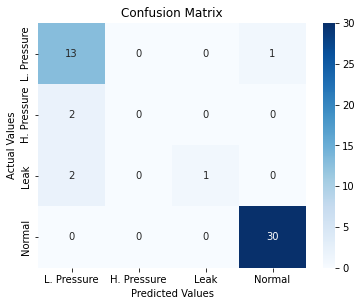

In [ ]:
# Abbreviate fault types
vals = ["L. Pressure", "H. Pressure", "Leak", "Normal"]

# Set up matrix
cm = metrics.confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=vals, columns=vals)

# Plot in Seaborn
plt.figure(figsize=(6, 4.5))
sns.heatmap(cm_df, annot=True, cmap="Blues").set(title="Confusion Matrix", ylabel="Actual Values", xlabel="Predicted Values")

# Display
plt.show()

### **Feature Importance**

No handles with labels found to put in legend.


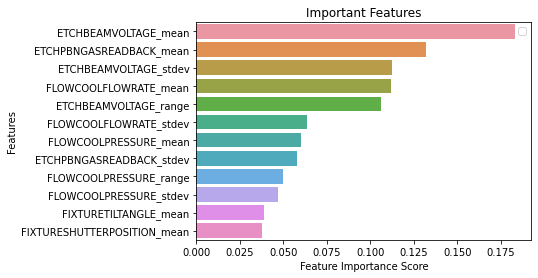

In [ ]:
feature_names = ['ETCHBEAMVOLTAGE_mean', 'ETCHBEAMVOLTAGE_stdev', 'ETCHBEAMVOLTAGE_range', 
                 'FLOWCOOLFLOWRATE_mean',	'FLOWCOOLFLOWRATE_stdev', 
                 'FLOWCOOLPRESSURE_mean', 'FLOWCOOLPRESSURE_stdev', 'FLOWCOOLPRESSURE_range',
                 'ETCHPBNGASREADBACK_mean', 'ETCHPBNGASREADBACK_stdev', 
                 'FIXTURETILTANGLE_mean', 
                 'FIXTURESHUTTERPOSITION_mean']

# Convert to Pandas Series
feature_imp = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Plot in Seaborn
sns.barplot(x=feature_imp, y=feature_imp.index).set(title="Important Features", ylabel="Features", xlabel="Feature Importance Score")
plt.legend()
plt.show()